In [2]:
import sys
!{sys.executable} -m pip install altair
!{sys.executable} -m pip install altair_data_server
!{sys.executable} -m pip install prince
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install scikeras

import pandas as pd
import numpy as np
import altair as alt
import prince
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [3]:
default_df = pd.read_excel('assets/default of credit card clients.xls', header=1, index_col=0)
default_df.rename(columns={'default payment next month': 'default', 'PAY_0': 'PAY_1'}, inplace=True)
default_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
# data transformation
def_cat_df = default_df.copy()
def_cat_df['AGE_GROUP'] = (def_cat_df.AGE / 10).apply(np.floor).astype(int)
def_cat_df['PAY_1_DUE'] = np.where(def_cat_df['PAY_1'] <= 0, 'YES', 'NO')
def_cat_df['PAY_2_DUE'] = np.where(def_cat_df['PAY_2'] <= 0, 'YES', 'NO')
def_cat_df['PAY_3_DUE'] = np.where(def_cat_df['PAY_3'] <= 0, 'YES', 'NO')
def_cat_df['PAY_4_DUE'] = np.where(def_cat_df['PAY_4'] <= 0, 'YES', 'NO')
def_cat_df['PAY_5_DUE'] = np.where(def_cat_df['PAY_5'] <= 0, 'YES', 'NO')
def_cat_df['PAY_6_DUE'] = np.where(def_cat_df['PAY_6'] <= 0, 'YES', 'NO')
def_cat_df = pd.get_dummies(def_cat_df, columns=['PAY_1_DUE', 'PAY_2_DUE', 'PAY_3_DUE', 'PAY_4_DUE', 'PAY_5_DUE', 'PAY_6_DUE'], drop_first=True)
def_cat_df.drop(columns=['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'AGE'], inplace=True)
def_cat_df['SEX'] = np.where(def_cat_df['SEX'] == 1, 'MALE', 'FEMALE')
def_cat_df = pd.get_dummies(def_cat_df, columns=['SEX'], drop_first=True)
def_cat_df = pd.get_dummies(def_cat_df, columns=['EDUCATION', 'MARRIAGE', 'AGE_GROUP'])
def_cat_df.head()

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,...,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,AGE_GROUP_2,AGE_GROUP_3,AGE_GROUP_4,AGE_GROUP_5,AGE_GROUP_6,AGE_GROUP_7
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,3913,3102,689,0,0,0,0,689,0,...,0,1,0,0,1,0,0,0,0,0
2,120000,2682,1725,2682,3272,3455,3261,0,1000,1000,...,0,0,1,0,1,0,0,0,0,0
3,90000,29239,14027,13559,14331,14948,15549,1518,1500,1000,...,0,0,1,0,0,1,0,0,0,0
4,50000,46990,48233,49291,28314,28959,29547,2000,2019,1200,...,0,1,0,0,0,1,0,0,0,0
5,50000,8617,5670,35835,20940,19146,19131,2000,36681,10000,...,0,1,0,0,0,0,0,1,0,0


## Dimensionality reduction experiment

Experimenting with the **prince** package here to attempt dimensionality reduction on data containing a mix of numeric/continuous and categorical variables (https://github.com/MaxHalford/prince#factor-analysis-of-mixed-data-famd).
Differences are noticeable, but clusters are not well separated in 2-dimensional feature space.

<AxesSubplot:title={'center':'Row principal coordinates'}, xlabel='Component 0 (18.40% inertia)', ylabel='Component 1 (9.67% inertia)'>

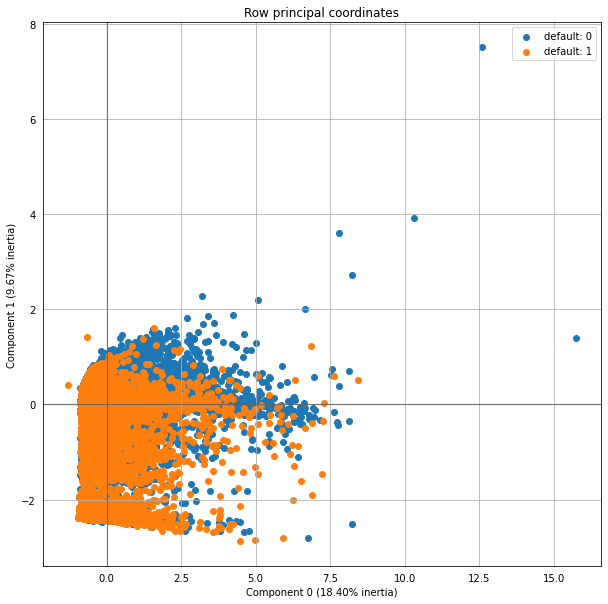

In [5]:
famd = prince.FAMD(random_state=42)
cat_cols = ['PAY_1_DUE_YES', 'PAY_2_DUE_YES', 'PAY_3_DUE_YES', 'PAY_4_DUE_YES', 'PAY_5_DUE_YES',
            'PAY_6_DUE_YES', 'SEX_MALE', 'EDUCATION_0', 'EDUCATION_1',
            'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5',
            'EDUCATION_6', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
            'AGE_GROUP_2', 'AGE_GROUP_3', 'AGE_GROUP_4', 'AGE_GROUP_5',
            'AGE_GROUP_6', 'AGE_GROUP_7']
def_cat_df[cat_cols] = def_cat_df[cat_cols].astype(str)
famd = famd.fit(def_cat_df.drop(['default'], axis=1))
famd.row_coordinates(def_cat_df)

famd.plot_row_coordinates(
    def_cat_df,
    ax=None,
    figsize=(10, 10),
    x_component=0,
    y_component=1,
    labels=None,
    color_labels=['default: {}'.format(d) for d in def_cat_df['default']],
    ellipse_outline=False,
    ellipse_fill=False,
    show_points=True
)